# Analytics

#### Date: 2021/01

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM:

##### Semester: 2021/01
##### Professor: Hilmer Neri

##### Members:

- 18/0113097 Daniel Coimbra
- 18/0075462 Gabriel Freitas Balbino
- 17/0145514 Iuri de Souza Severo Alves
- 17/0013910 João Pedro José
- 16/0133394 Lucas Fellipe Carvalho Moreira
- 20/0025449 Natan Tavares Santana
- 19/0109963 João Victor Teixeira Batista
- 19/0094257 Paulo Henrique
- 17/0062686 Pedro Rodrigues

### LIBRARIES

In [1]:
# Deal with data
import pandas as pd
import numpy as np
import json
from glob import glob
import os

# Deal with API request
import urllib3
from urllib3 import request

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Deal with time
import datetime

### GRAPH SETTINGS

In [2]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

### DATAFRAME SETTINGS

In [3]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

### SonarCloud

##### Path to the folder with all your jsons

In [4]:
jsons = glob('../analytics-raw-data/*.json') # add the path here
print(jsons[0])

../analytics-raw-data/fga-eps-mds-2021.1-Pro-Especies-FishWiki-10-27-2021-18-11.json


In [5]:
def read_json(json_path):
    
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
        
    return json_obj

def create_base_component_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        base_component = read_json(i)

        base_component_data = base_component['baseComponent']['measures']

        base_component_df = pd.DataFrame(base_component_data)

        base_component_df['filename'] = os.path.basename(i)

        df = df.append(base_component_df, ignore_index=True)
        
    aux_df = df['filename'].str.split(r"Pro-Especies-(.*?)-(.*?).json", expand=True)
    
    df['repository'] = aux_df[1]
    
    df['version'] = aux_df[2]
    
    df = df.sort_values(by=['repository', 'version'])
        
    return df

#### Create base component dataframe

In [6]:
base_component_df = create_base_component_df(jsons)

In [7]:
base_component_df.head(10)

,metric,value,bestValue,filename,repository,version
312,complexity,1,NaN,fga-eps-mds-2021.1-Pro-Especies-FishLog-09-13-...,FishLog,09-13-2021-21-00
313,duplicated_lines_density,0.0,True,fga-eps-mds-2021.1-Pro-Especies-FishLog-09-13-...,FishLog,09-13-2021-21-00
314,functions,1,NaN,fga-eps-mds-2021.1-Pro-Especies-FishLog-09-13-...,FishLog,09-13-2021-21-00
315,ncloc,11,NaN,fga-eps-mds-2021.1-Pro-Especies-FishLog-09-13-...,FishLog,09-13-2021-21-00
316,reliability_rating,1.0,True,fga-eps-mds-2021.1-Pro-Especies-FishLog-09-13-...,FishLog,09-13-2021-21-00
317,security_rating,1.0,True,fga-eps-mds-2021.1-Pro-Especies-FishLog-09-13-...,FishLog,09-13-2021-21-00
318,comment_lines_density,0.0,False,fga-eps-mds-2021.1-Pro-Especies-FishLog-09-13-...,FishLog,09-13-2021-21-00
319,files,7,NaN,fga-eps-mds-2021.1-Pro-Especies-FishLog-09-13-...,FishLog,09-13-2021-21-00
96,duplicated_lines_density,0.0,True,fga-eps-mds-2021.1-Pro-Especies-FishLog-09-15-...,FishLog,09-15-2021-22-42
97,functions,19,NaN,fga-eps-mds-2021.1-Pro-Especies-FishLog-09-15-...,FishLog,09-15-2021-22-42


#### Create dataframe per file

In [8]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'security_rating',
               'tests',
               'test_success_density',
               'test_execution_time',
               'reliability_rating']

len(metric_list)

12

In [9]:
def metric_per_file(json):
    
    file_json = []
    
    for component in json['components']:
        if component['qualifier'] == 'FIL':
            file_json.append(component)
            
    return file_json

def generate_file_dataframe_per_release(metric_list, json, language_extension):
    
    df_columns = metric_list
    df = pd.DataFrame(columns = df_columns)
    
    for file in json:
        try:
            if file['language'] == language_extension:
                for measure in file['measures']:
                    df.at[file['path'], measure['metric']] = measure['value']
        except:
            pass
        
    df.reset_index(inplace = True)
    df = df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    return df

def create_file_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        file_component = read_json(i)
        
        file_component_data = metric_per_file(file_component)

        file_component_df = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'ts')

        file_component_df['filename'] = os.path.basename(i)
        df = df.append(file_component_df, ignore_index=True)
        
    # replace TeamName by yours.    
    aux_df = df['filename'].str.split(r"Pro-Especies-(.*?)-(.*?).json", expand=True)
    
    df['repository'] = aux_df[1]
    
    df['version'] = aux_df[2]
    
    df = df.sort_values(by=['repository', 'version'])
        
    return df

In [10]:
file_component_df = create_file_df(jsons)

In [11]:
file_component_df.head(10)

,path,functions,complexity,comment_lines_density,duplicated_lines_density,coverage,ncloc,security_rating,tests,test_success_density,test_execution_time,reliability_rating,filename,repository,version
533,src/index.ts,1,1,0.0,0.0,NaN,5,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021.1-Pro-Especies-FishLog-09-13-...,FishLog,09-13-2021-21-00
194,src/app.ts,0,0,0.0,0.0,NaN,11,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021.1-Pro-Especies-FishLog-09-15-...,FishLog,09-15-2021-22-42
195,src/middleware/auth.ts,3,5,0.0,0.0,38.9,31,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021.1-Pro-Especies-FishLog-09-15-...,FishLog,09-15-2021-22-42
196,src/config/database.ts,2,4,0.0,0.0,NaN,27,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021.1-Pro-Especies-FishLog-09-15-...,FishLog,09-15-2021-22-42
197,src/models/fishLog.ts,0,0,0.0,0.0,100.0,89,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021.1-Pro-Especies-FishLog-09-15-...,FishLog,09-15-2021-22-42
198,src/controllers/fishLogController.ts,7,26,0.0,0.0,91.5,189,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021.1-Pro-Especies-FishLog-09-15-...,FishLog,09-15-2021-22-42
199,src/routes/fishLogRoutes.ts,6,6,0.0,0.0,0.0,25,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021.1-Pro-Especies-FishLog-09-15-...,FishLog,09-15-2021-22-42
200,src/routes/router.ts,0,0,16.7,0.0,NaN,5,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021.1-Pro-Especies-FishLog-09-15-...,FishLog,09-15-2021-22-42
201,src/server.ts,1,2,0.0,0.0,NaN,5,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021.1-Pro-Especies-FishLog-09-15-...,FishLog,09-15-2021-22-42
250,src/app.ts,0,0,0.0,0.0,NaN,11,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021.1-Pro-Especies-FishLog-10-18-...,FishLog,10-18-2021-06-28


#### Create dataframe per repository

In [12]:
repo1_df = file_component_df[file_component_df['repository'] == 'UserInterface']
repo2_df = file_component_df[file_component_df['repository'] == 'User']
repo3_df = file_component_df[file_component_df['repository'] == 'FishWiki']
repo4_df = file_component_df[file_component_df['repository'] == 'FishLog']

In [13]:
def _ncloc(df):
    ncloc = 0
    for each in df['ncloc']:
        n = 0
        # try to cast the current ncloc value to int, if the value is NaN/Null, consider it as zero.
        try:
            n = int(each)
        except ValueError:
            n = 0
        ncloc += n

    return ncloc

### Measure calculations according Q-Rapids quality model

# Quality Aspect - Maintainability
## Factor - Code Quality

##### COMPLEXITY

In [14]:
def m1(df):
    
    density_non_complex_files = len(df[(df['complexity'].astype(float)/df['functions'].astype(float)) < 10])/len(df)
    
    return density_non_complex_files

##### COMMENTS

In [15]:
def m2(df):
    
    density_comment_files = len(df[(df['comment_lines_density'].astype(float) > 10) & (df['comment_lines_density'].astype(float) < 30)])/len(df)
    
    return density_comment_files

##### DUPLICATIONS

In [16]:
def m3(df):
    
    duplication = len(df[(df['duplicated_lines_density'].astype(float) < 5)])/len(df)
    
    return duplication

# Quality Aspect - Reliability
## Factor - Testing Status

##### Passed tests

In [17]:
def m4(df):

    passed_tests = df['test_success_density'].astype(float).median() / 100

    return passed_tests

##### Fast test builds

In [18]:
def m5(df):

    density_fast_test_builds = len(df[(df['test_execution_time'].astype(float)) < 300]) / sum(df['tests'].astype(float))

    return density_fast_test_builds

##### Test coverage

In [19]:
def m6(df):

    density_test_coverage = len(df[(df['coverage'].astype(float) > 60)]) / len(df)

    return density_test_coverage

### Calculate m1, m2, m3, m4, m5 and m6 for each repository

In [20]:
def create_metrics_df(df):
    version_vec = df['version'].unique()
    
    m1_list = []
    m2_list = []
    m3_list = []
    m4_list = []
    m5_list = []
    m6_list = []

    ncloc_list = []
    repository_list = []
    version_list = []
    
    metrics_df = pd.DataFrame()
    for version in version_vec:
        version_df = df[df['version'] == version]

        m1_list.append(m1(version_df))
        m2_list.append(m2(version_df))
        m3_list.append(m3(version_df))
        m4_list.append(m3(version_df))
        m5_list.append(m3(version_df))
        m6_list.append(m3(version_df))

        ncloc_list.append(_ncloc(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)
        
    metrics_df = pd.DataFrame({'m1': m1_list,
                               'm2': m2_list,
                               'm3': m3_list,
                               'm4': m3_list,
                               'm5': m3_list,
                               'm6': m3_list,
                               'repository': repository_list, 
                               'version': version_list,
                               'ncloc': ncloc_list})
        
    return metrics_df

In [21]:
repo1_metrics = create_metrics_df(repo1_df)
repo2_metrics = create_metrics_df(repo2_df)
repo3_metrics = create_metrics_df(repo3_df)
repo4_metrics = create_metrics_df(repo4_df)

### Data visualization

- You must do this for each of your repositories

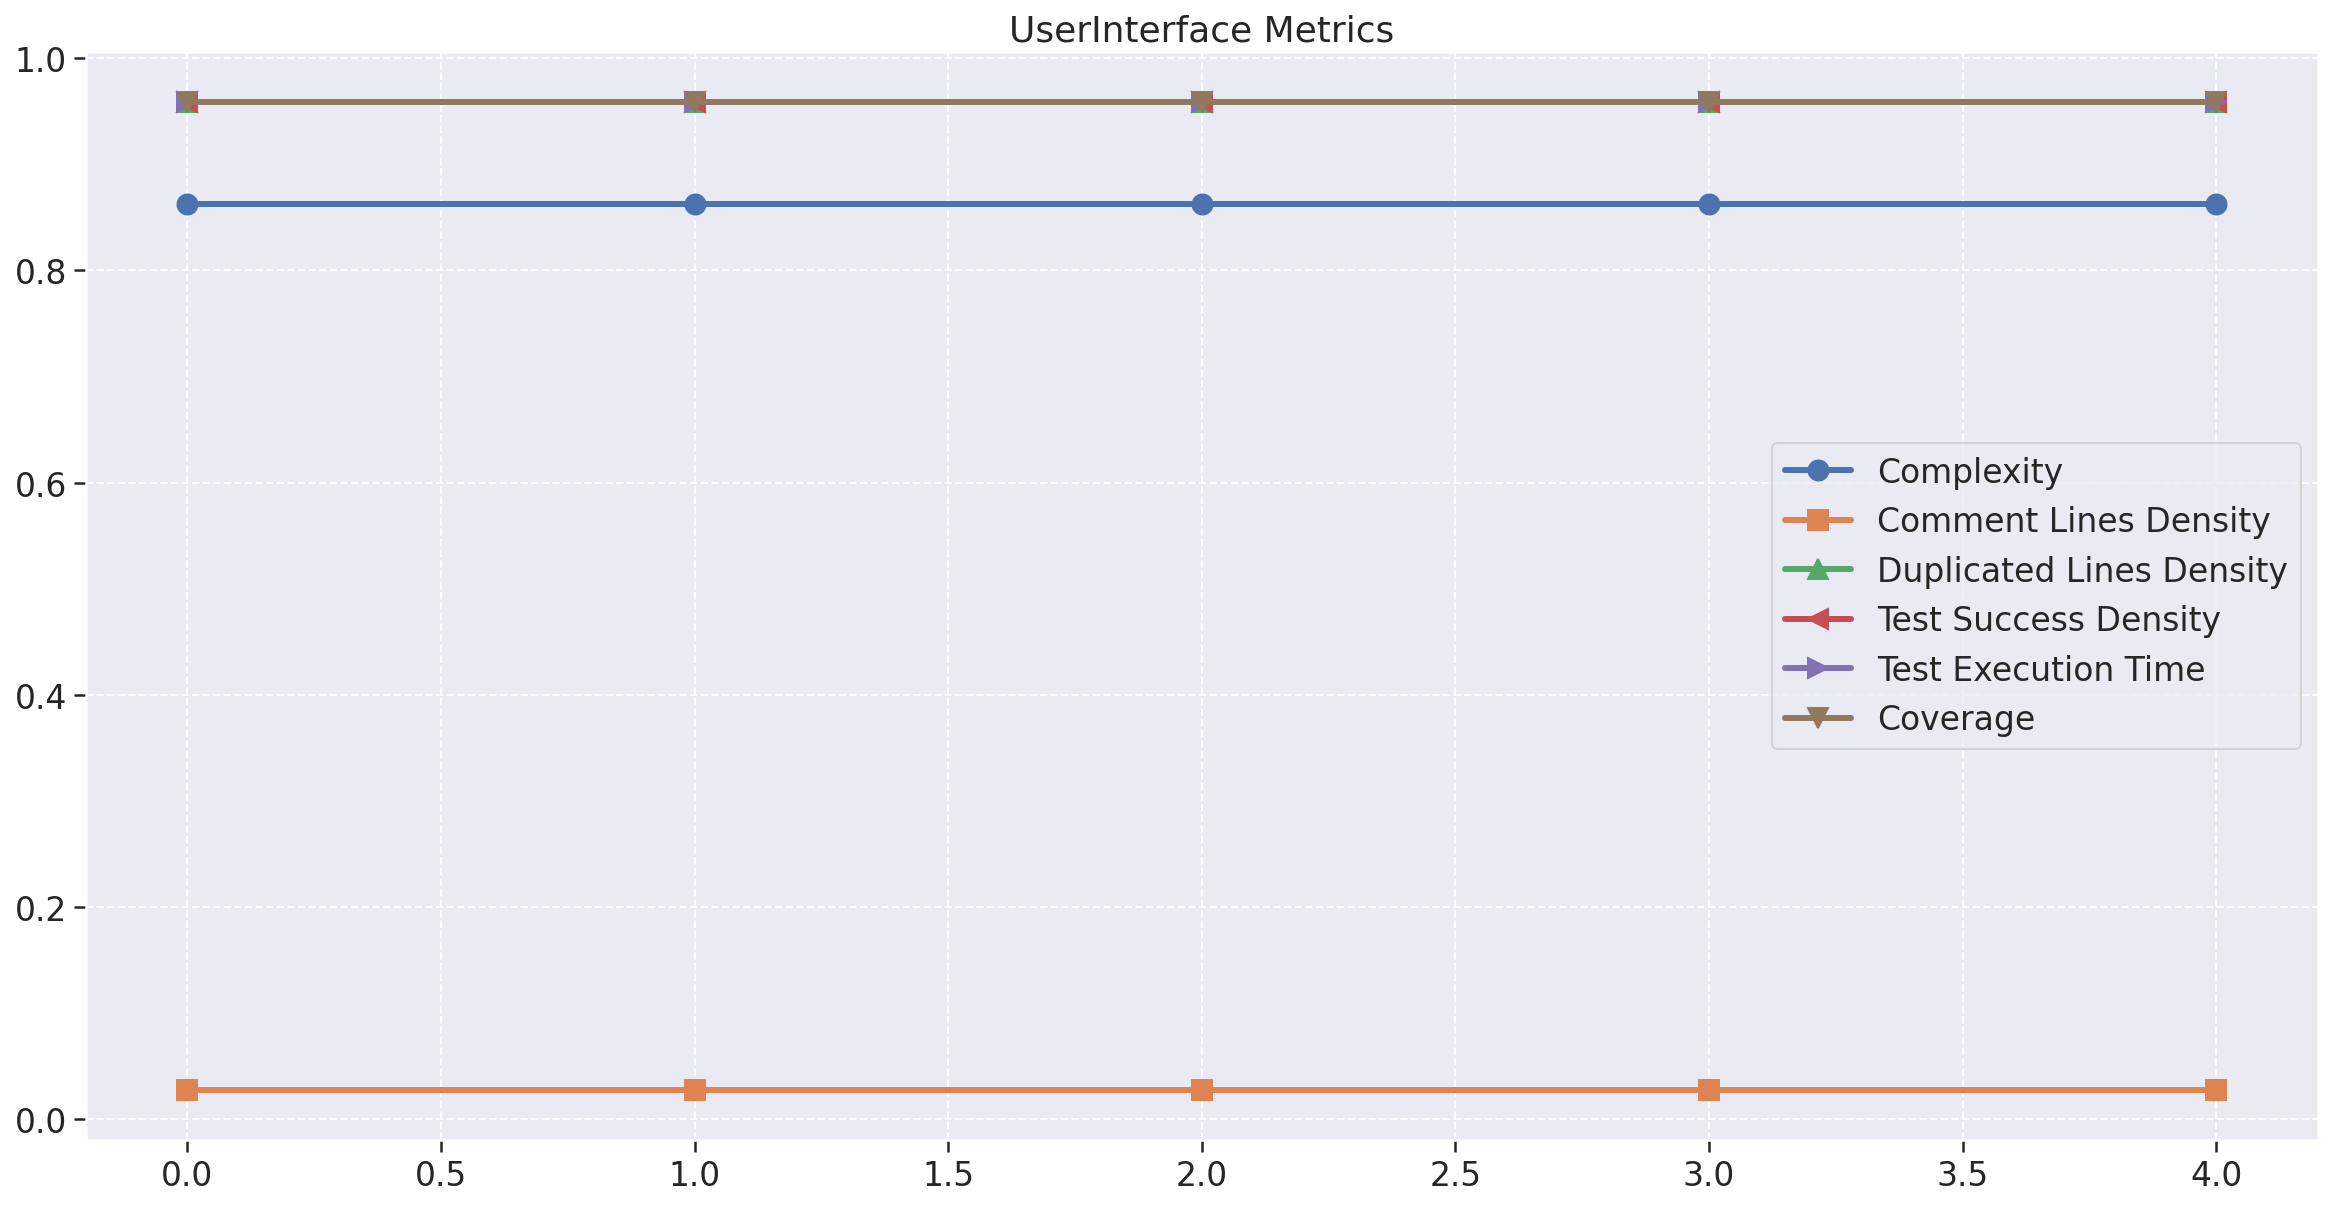

In [22]:
fig = plt.figure(figsize=(20, 10))

plt.title('UserInterface Metrics')
plt.plot(repo1_metrics['m1'], linewidth=3, marker='o', label='Complexity', markersize=10)
plt.plot(repo1_metrics['m2'], linewidth=3, marker='s', label='Comment Lines Density', markersize=10)
plt.plot(repo1_metrics['m3'], linewidth=3, marker='^', label='Duplicated Lines Density', markersize=10)
plt.plot(repo1_metrics['m4'], linewidth=3, marker='<', label='Test Success Density', markersize=10)
plt.plot(repo1_metrics['m5'], linewidth=3, marker='>', label='Test Execution Time', markersize=10)
plt.plot(repo1_metrics['m6'], linewidth=3, marker='v', label='Coverage', markersize=10)
plt.legend()

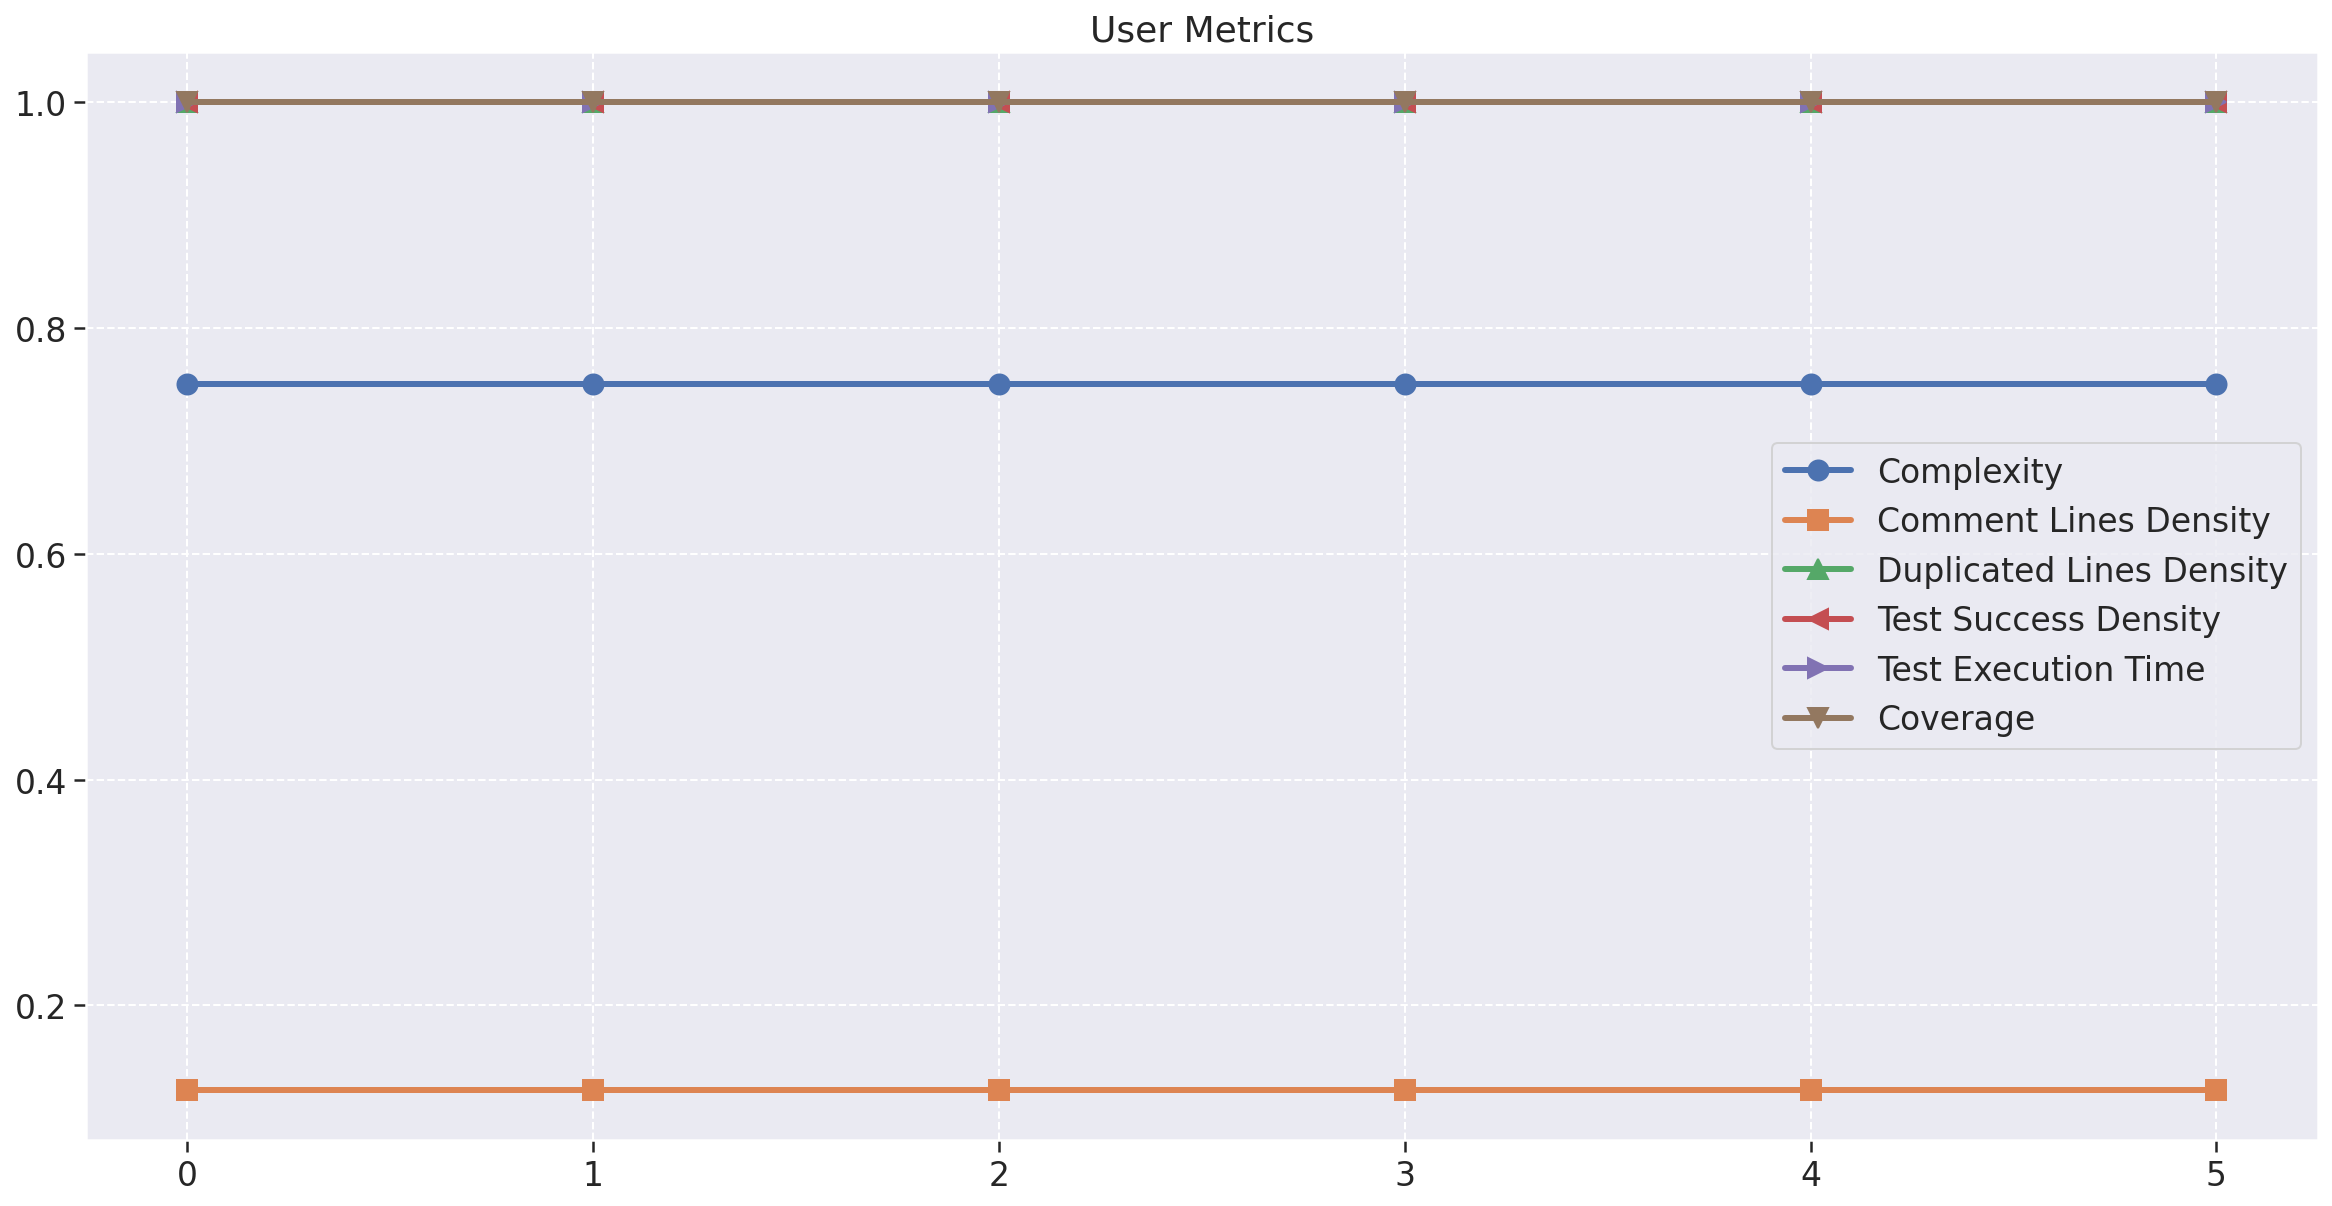

In [23]:
fig = plt.figure(figsize=(20, 10))

plt.title('User Metrics')
plt.plot(repo2_metrics['m1'], linewidth=3, marker='o', label='Complexity', markersize=10)
plt.plot(repo2_metrics['m2'], linewidth=3, marker='s', label='Comment Lines Density', markersize=10)
plt.plot(repo2_metrics['m3'], linewidth=3, marker='^', label='Duplicated Lines Density', markersize=10)
plt.plot(repo2_metrics['m4'], linewidth=3, marker='<', label='Test Success Density', markersize=10)
plt.plot(repo2_metrics['m5'], linewidth=3, marker='>', label='Test Execution Time', markersize=10)
plt.plot(repo2_metrics['m6'], linewidth=3, marker='v', label='Coverage', markersize=10)
plt.legend()

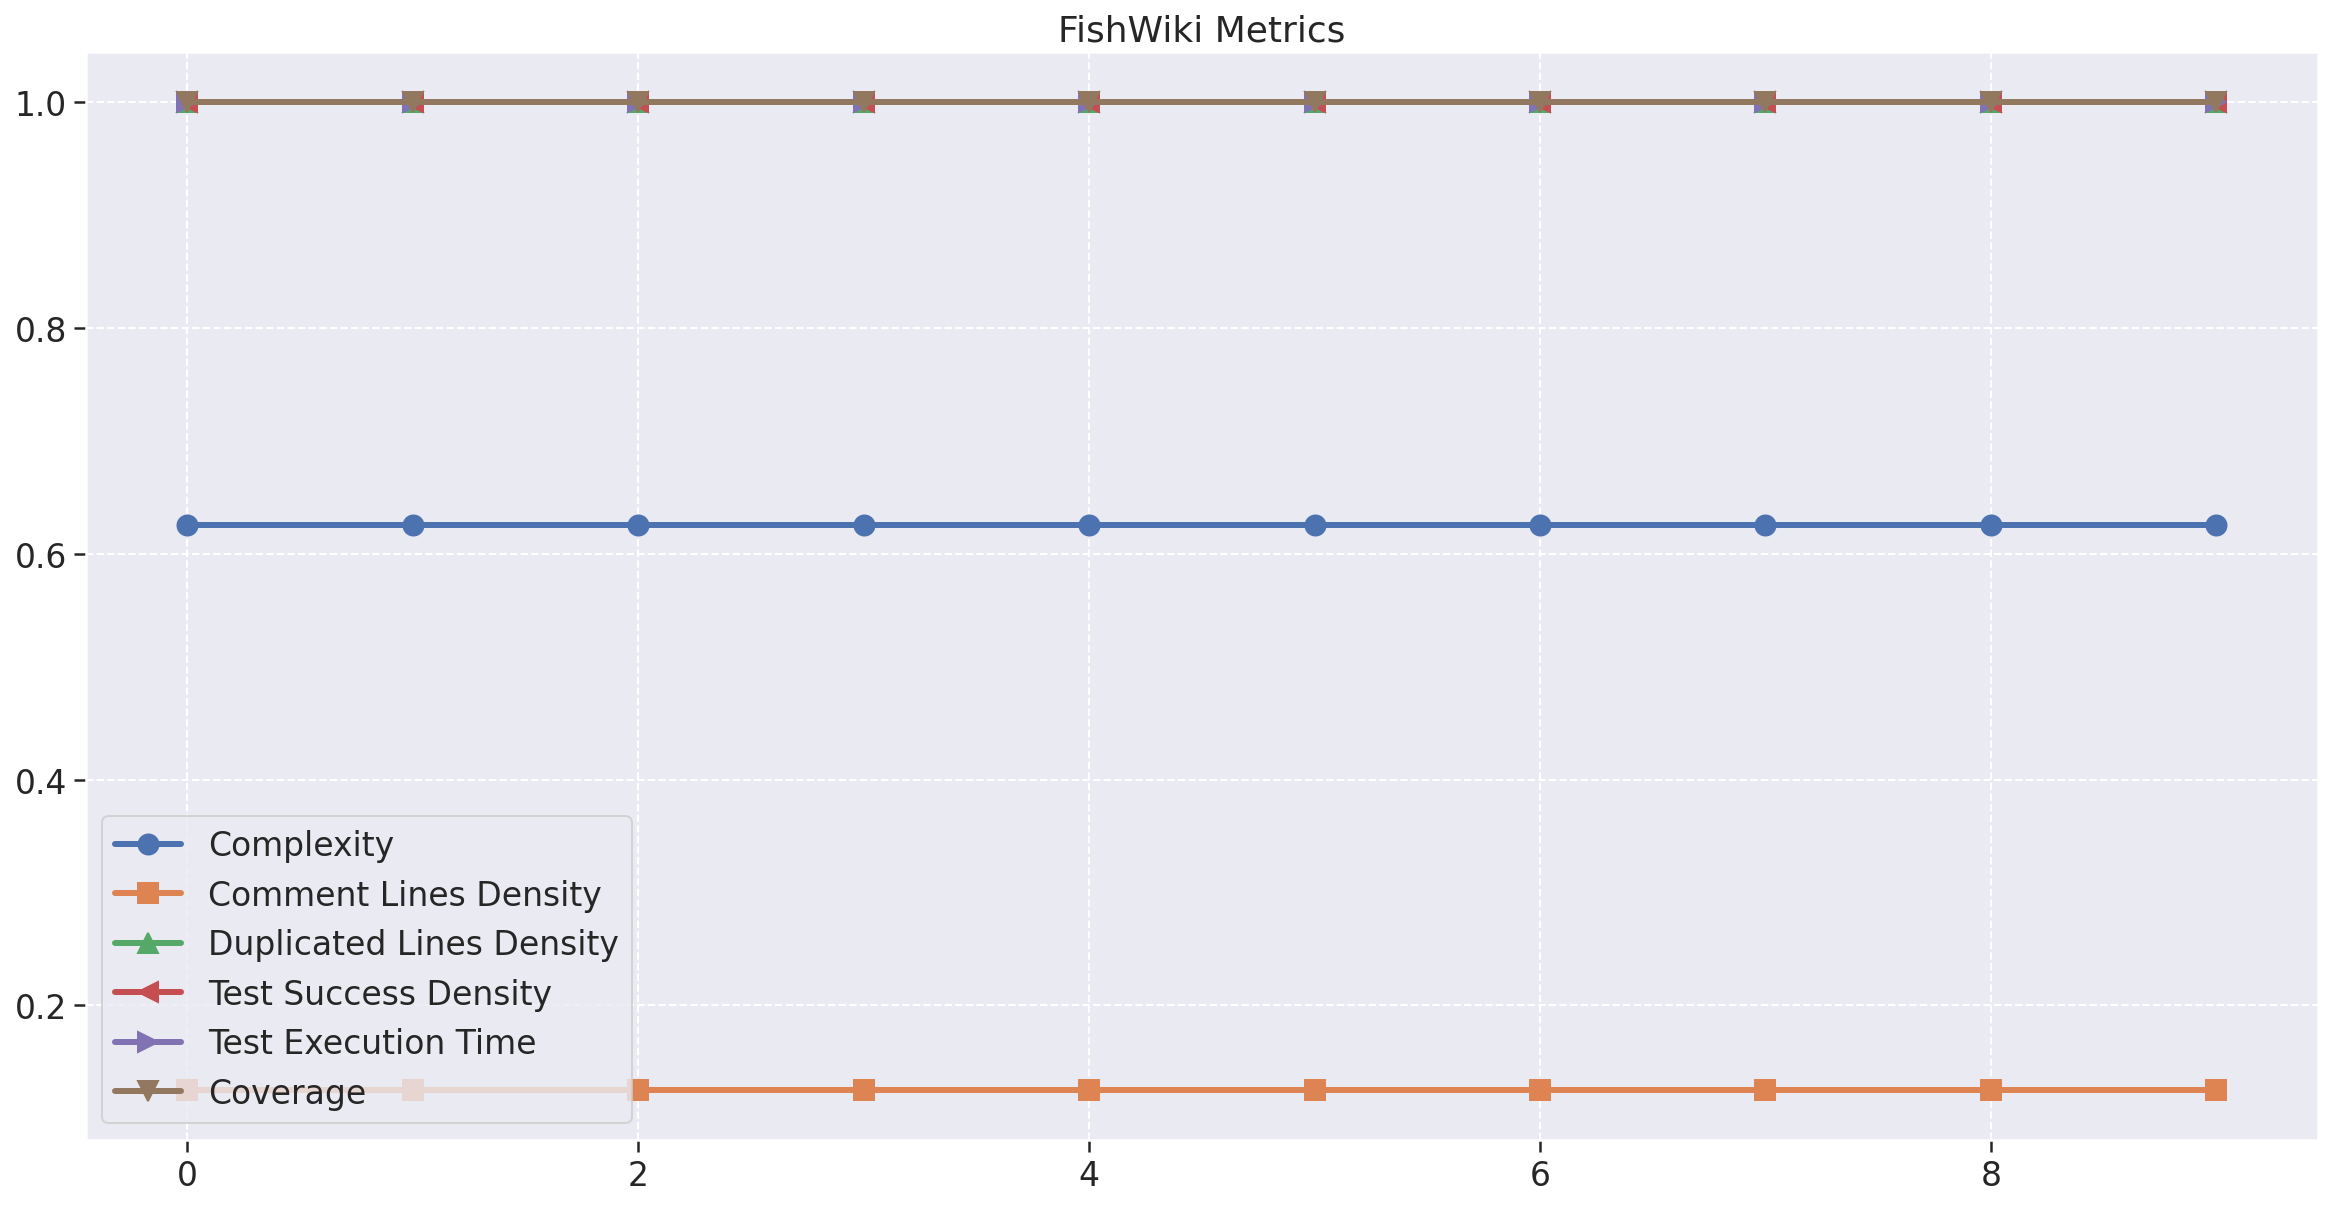

In [24]:
fig = plt.figure(figsize=(20, 10))

plt.title('FishWiki Metrics')
plt.plot(repo3_metrics['m1'], linewidth=3, marker='o', label='Complexity', markersize=10)
plt.plot(repo3_metrics['m2'], linewidth=3, marker='s', label='Comment Lines Density', markersize=10)
plt.plot(repo3_metrics['m3'], linewidth=3, marker='^', label='Duplicated Lines Density', markersize=10)
plt.plot(repo3_metrics['m4'], linewidth=3, marker='<', label='Test Success Density', markersize=10)
plt.plot(repo3_metrics['m5'], linewidth=3, marker='>', label='Test Execution Time', markersize=10)
plt.plot(repo3_metrics['m6'], linewidth=3, marker='v', label='Coverage', markersize=10)
plt.legend()

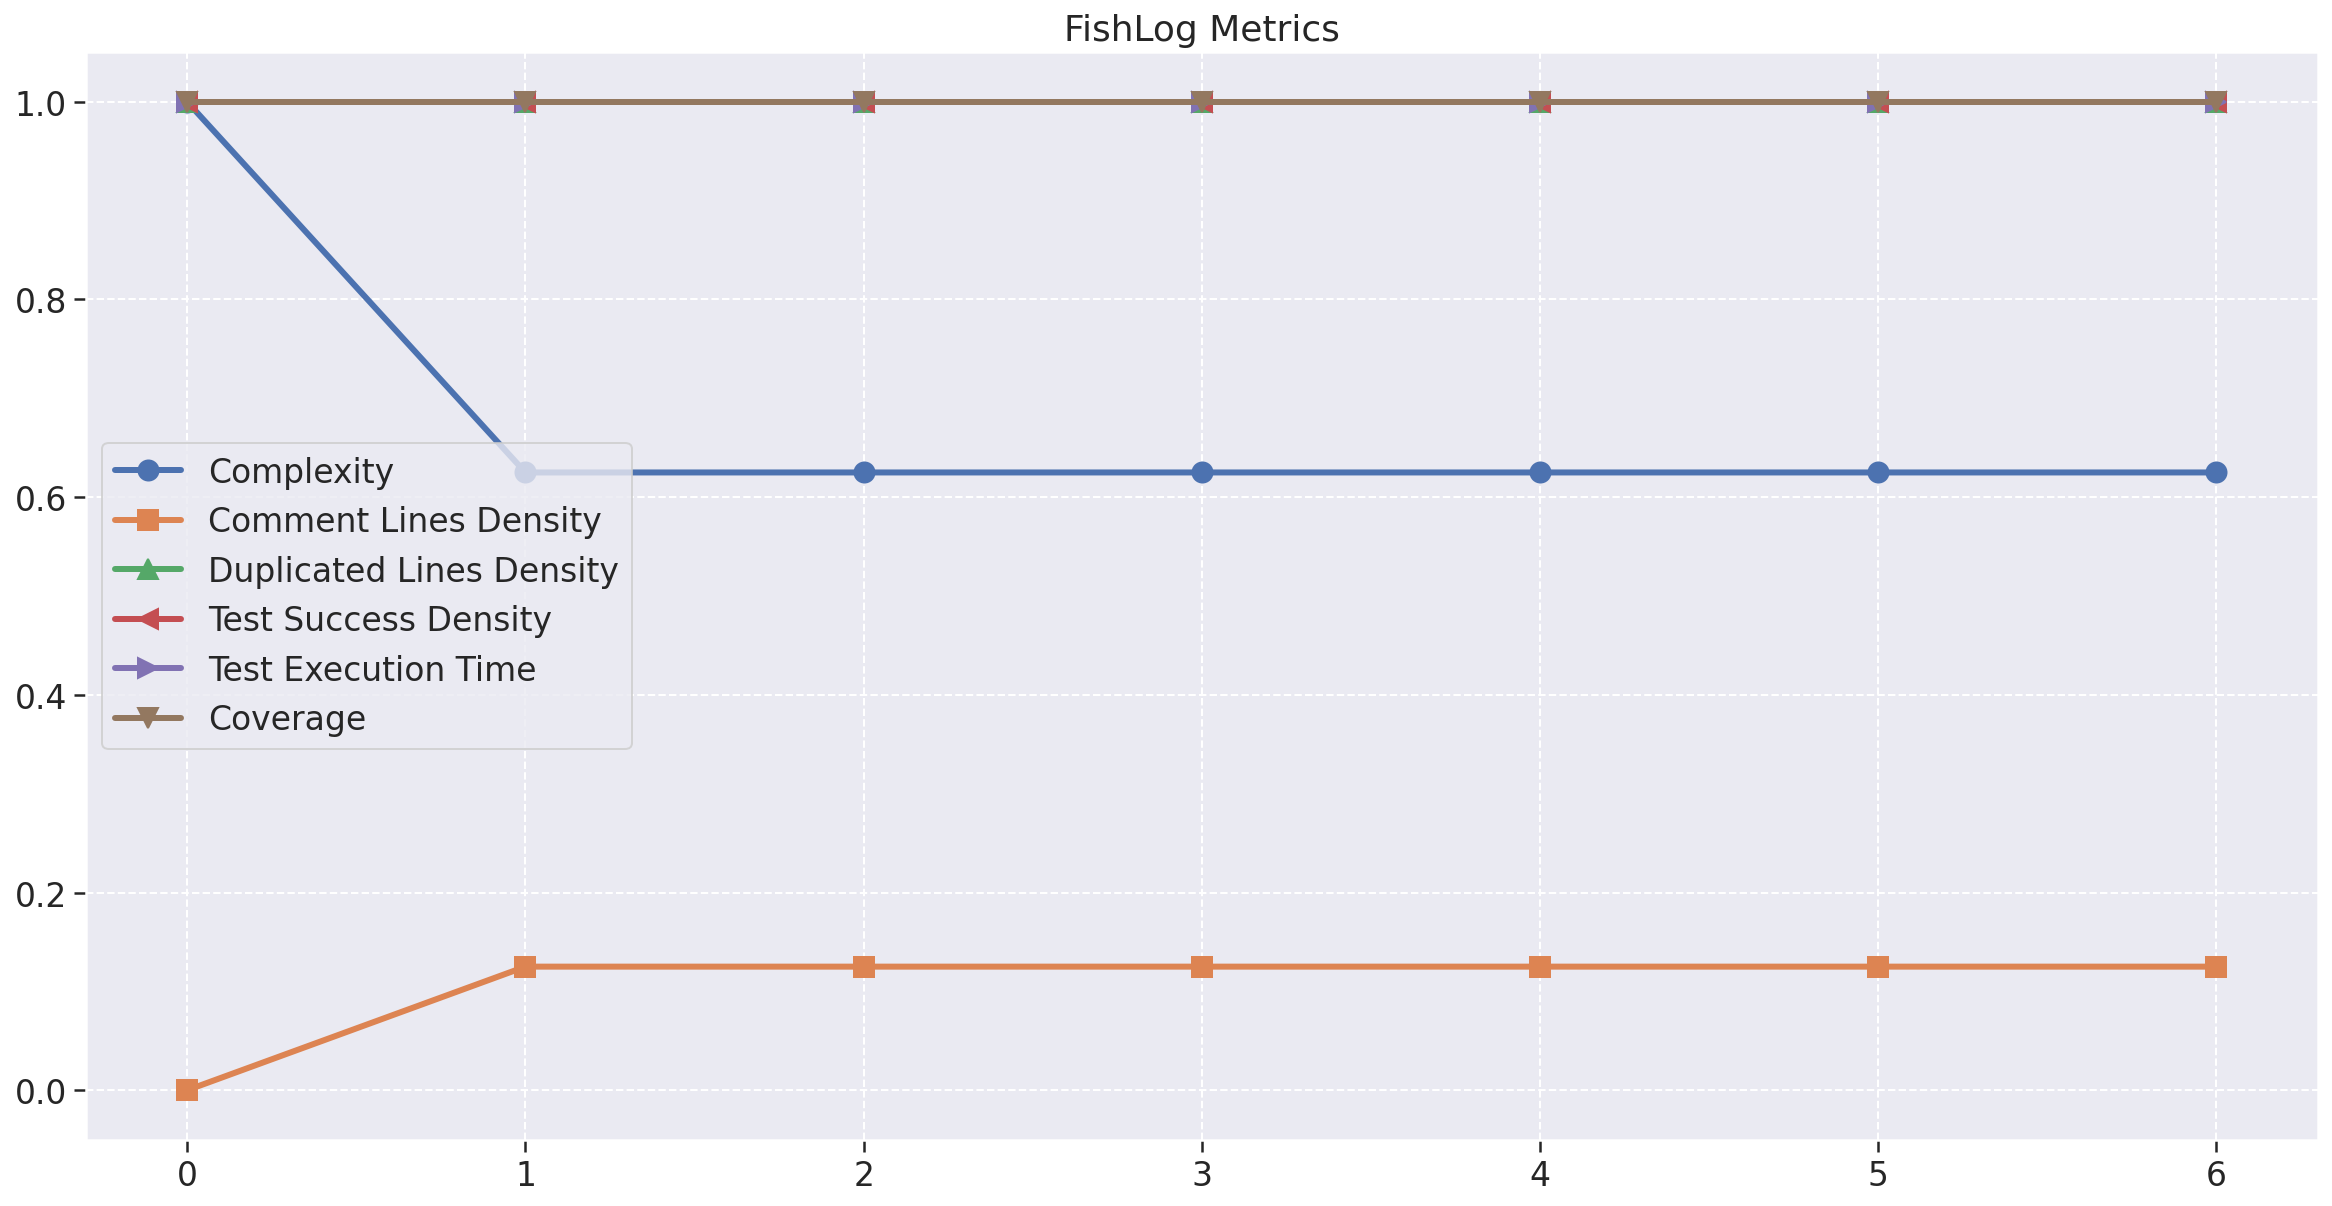

In [25]:
fig = plt.figure(figsize=(20, 10))

plt.title('FishLog Metrics')
plt.plot(repo4_metrics['m1'], linewidth=3, marker='o', label='Complexity', markersize=10)
plt.plot(repo4_metrics['m2'], linewidth=3, marker='s', label='Comment Lines Density', markersize=10)
plt.plot(repo4_metrics['m3'], linewidth=3, marker='^', label='Duplicated Lines Density', markersize=10)
plt.plot(repo4_metrics['m4'], linewidth=3, marker='<', label='Test Success Density', markersize=10)
plt.plot(repo4_metrics['m5'], linewidth=3, marker='>', label='Test Execution Time', markersize=10)
plt.plot(repo4_metrics['m6'], linewidth=3, marker='v', label='Coverage', markersize=10)
plt.legend()

### Sub characteristic aggregation

- You must do this for each of your repositories

In [26]:
psc1 = 1
psc2 = 1
pc1 = 0.5
pc2 = 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33
pm4 = 0.15
pm5 = 0.15
pm6 = 0.7

repo1_metrics['code_quality'] = ((repo1_metrics['m1']*pm1) + (repo1_metrics['m2']*pm2) + (repo1_metrics['m3']*pm3)) * psc1
repo2_metrics['code_quality'] = ((repo2_metrics['m1']*pm1) + (repo2_metrics['m2']*pm2) + (repo2_metrics['m3']*pm3)) * psc1
repo3_metrics['code_quality'] = ((repo3_metrics['m1']*pm1) + (repo3_metrics['m2']*pm2) + (repo3_metrics['m3']*pm3)) * psc1
repo4_metrics['code_quality'] = ((repo4_metrics['m1']*pm1) + (repo4_metrics['m2']*pm2) + (repo4_metrics['m3']*pm3)) * psc1

repo1_metrics['testing_status'] = ((repo1_metrics['m4']*pm4) + (repo1_metrics['m5']*pm5) + (repo1_metrics['m6']*pm6)) * psc2
repo2_metrics['testing_status'] = ((repo2_metrics['m4']*pm4) + (repo2_metrics['m5']*pm5) + (repo2_metrics['m6']*pm6)) * psc2
repo3_metrics['testing_status'] = ((repo3_metrics['m4']*pm4) + (repo3_metrics['m5']*pm5) + (repo3_metrics['m6']*pm6)) * psc2
repo4_metrics['testing_status'] = ((repo4_metrics['m4']*pm4) + (repo4_metrics['m5']*pm5) + (repo4_metrics['m6']*pm6)) * psc2


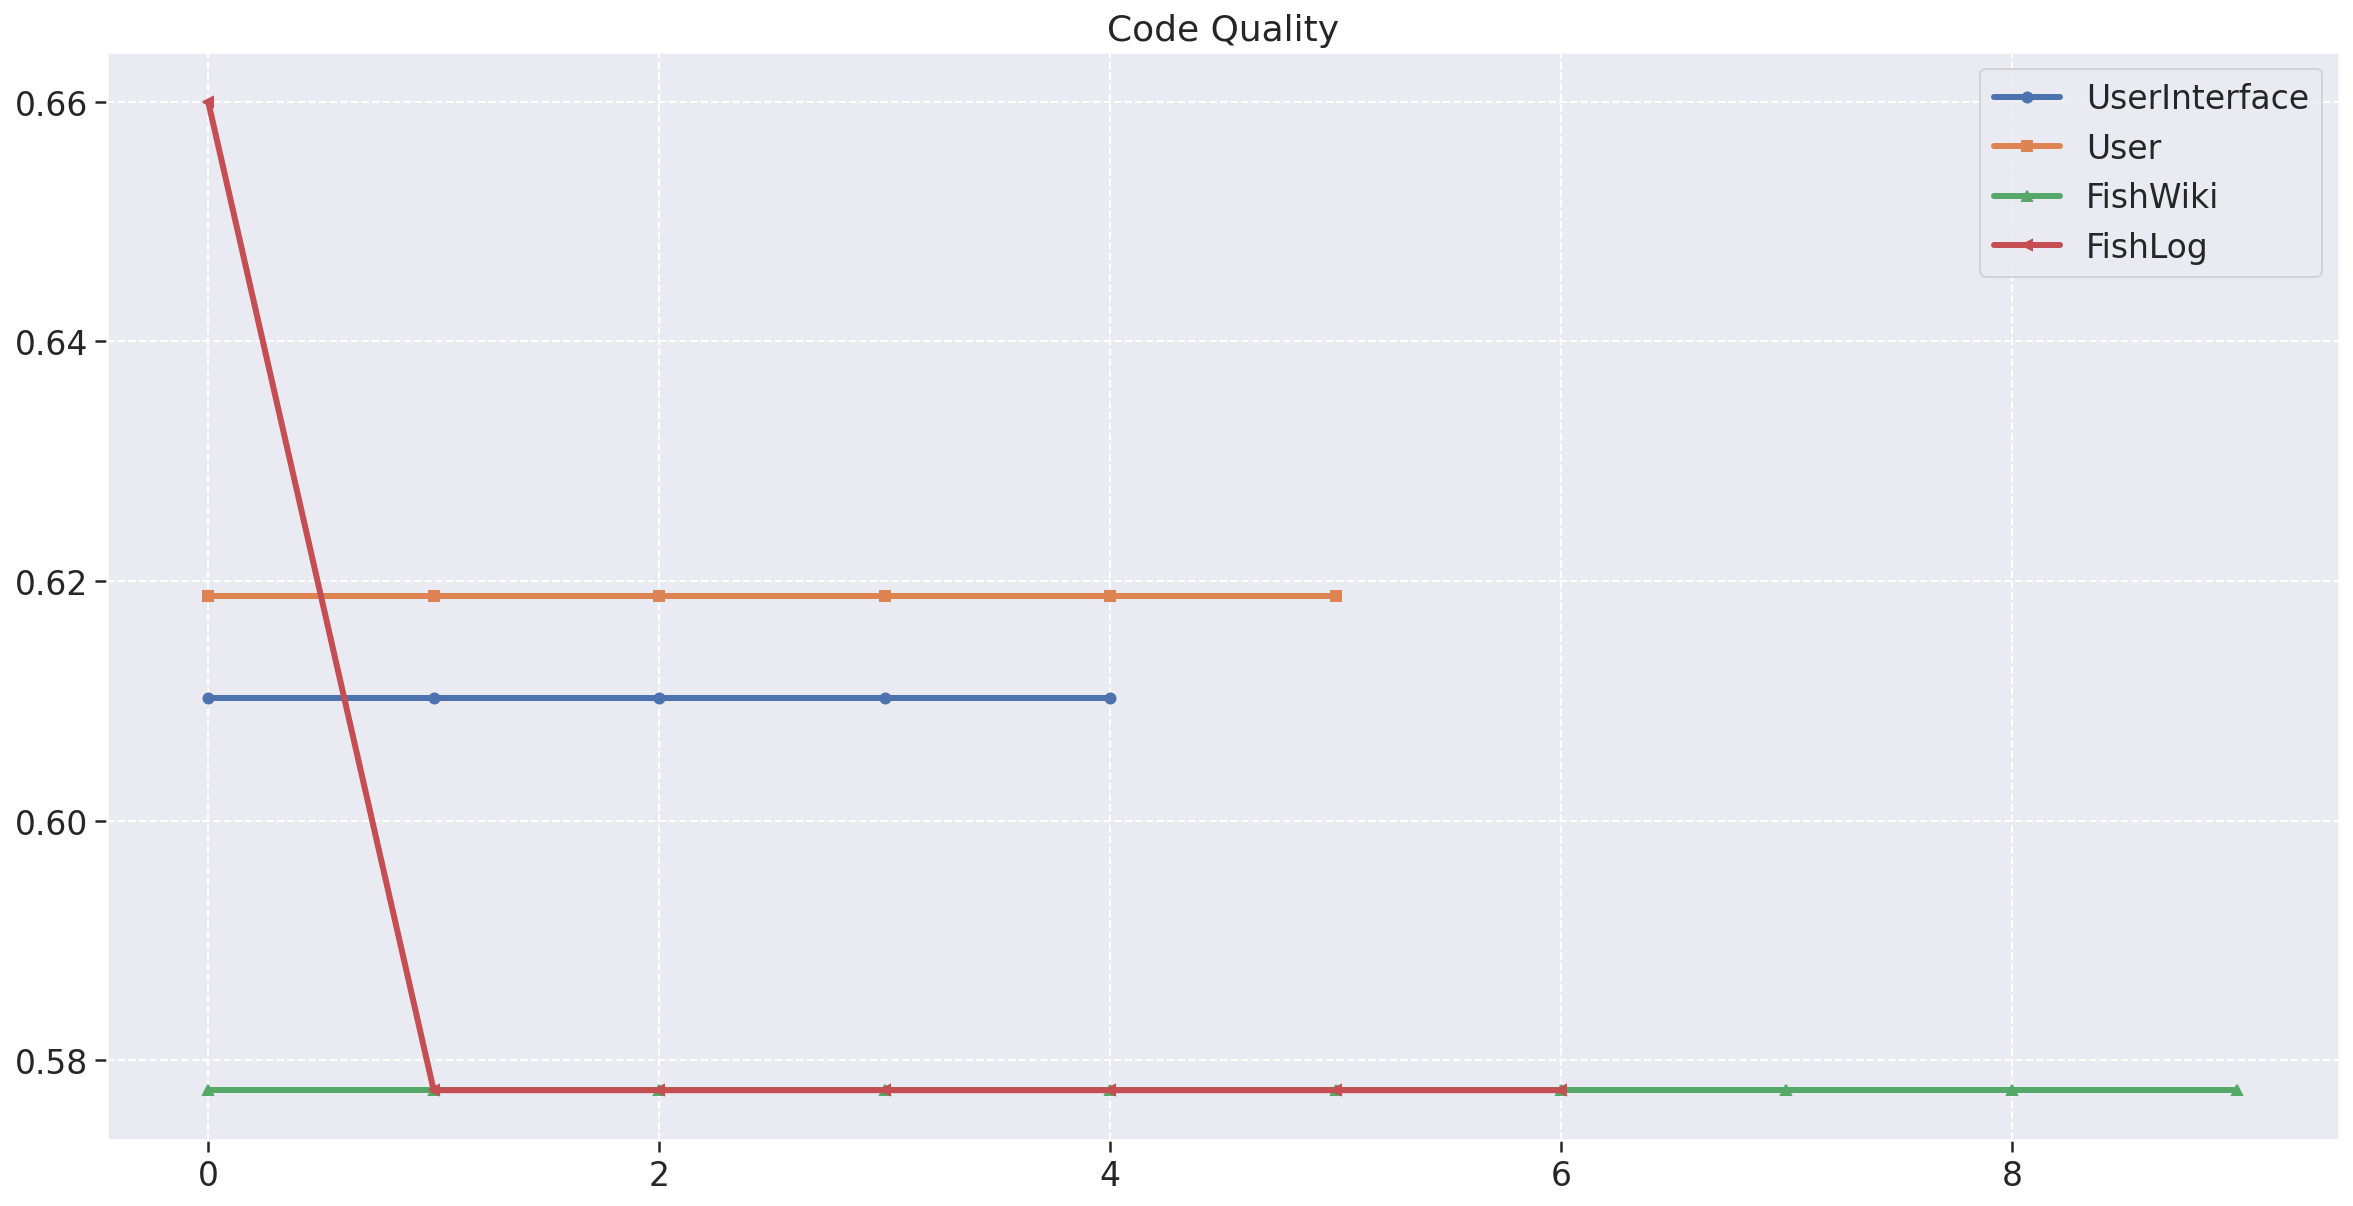

In [27]:
fig = plt.figure(figsize=(20, 10))

plt.title('Code Quality')
plt.plot(repo1_metrics['code_quality'], linewidth=3, marker='o', label='UserInterface', markersize=5)
plt.plot(repo2_metrics['code_quality'], linewidth=3, marker='s', label='User', markersize=5)
plt.plot(repo3_metrics['code_quality'], linewidth=3, marker='^', label='FishWiki', markersize=5)
plt.plot(repo4_metrics['code_quality'], linewidth=3, marker='<', label='FishLog', markersize=5)
plt.legend()

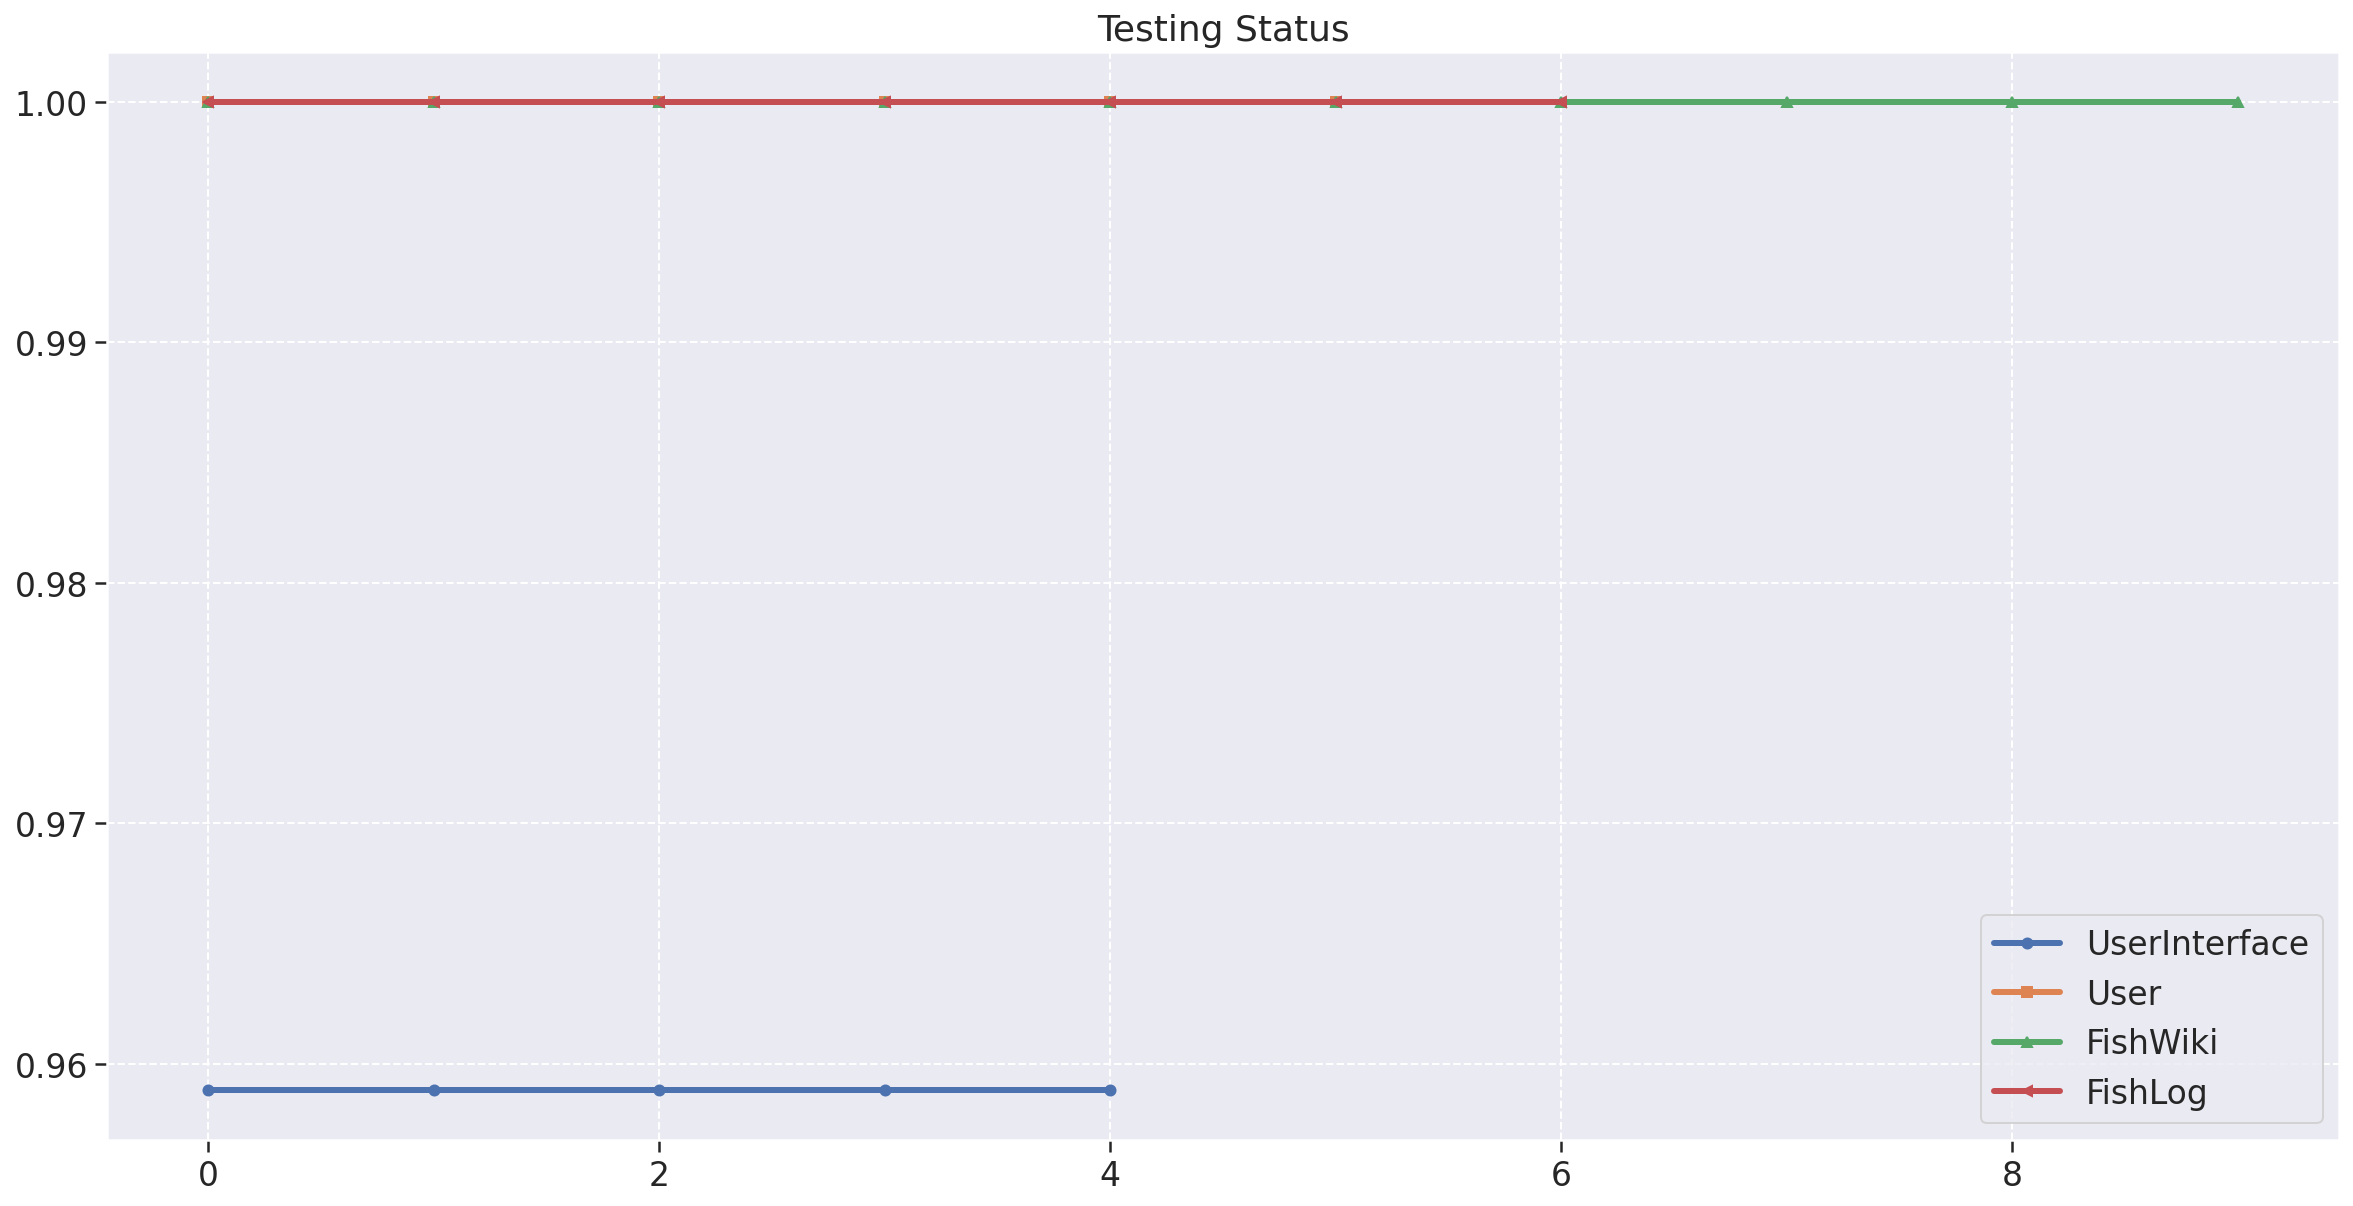

In [28]:
fig = plt.figure(figsize=(20, 10))

plt.title('Testing Status')
plt.plot(repo1_metrics['testing_status'], linewidth=3, marker='o', label='UserInterface', markersize=5)
plt.plot(repo2_metrics['testing_status'], linewidth=3, marker='s', label='User', markersize=5)
plt.plot(repo3_metrics['testing_status'], linewidth=3, marker='^', label='FishWiki', markersize=5)
plt.plot(repo4_metrics['testing_status'], linewidth=3, marker='<', label='FishLog', markersize=5)
plt.legend()

In [29]:
metrics_df = pd.concat([repo1_metrics, repo2_metrics, repo3_metrics, repo4_metrics], ignore_index=True)

metrics_df['maintainability'] = metrics_df['code_quality'] * pc1
metrics_df['Reliability'] = metrics_df['testing_status'] * pc2
metrics_df['total'] = metrics_df['maintainability'] + metrics_df['Reliability']

(0.2, 0.6)

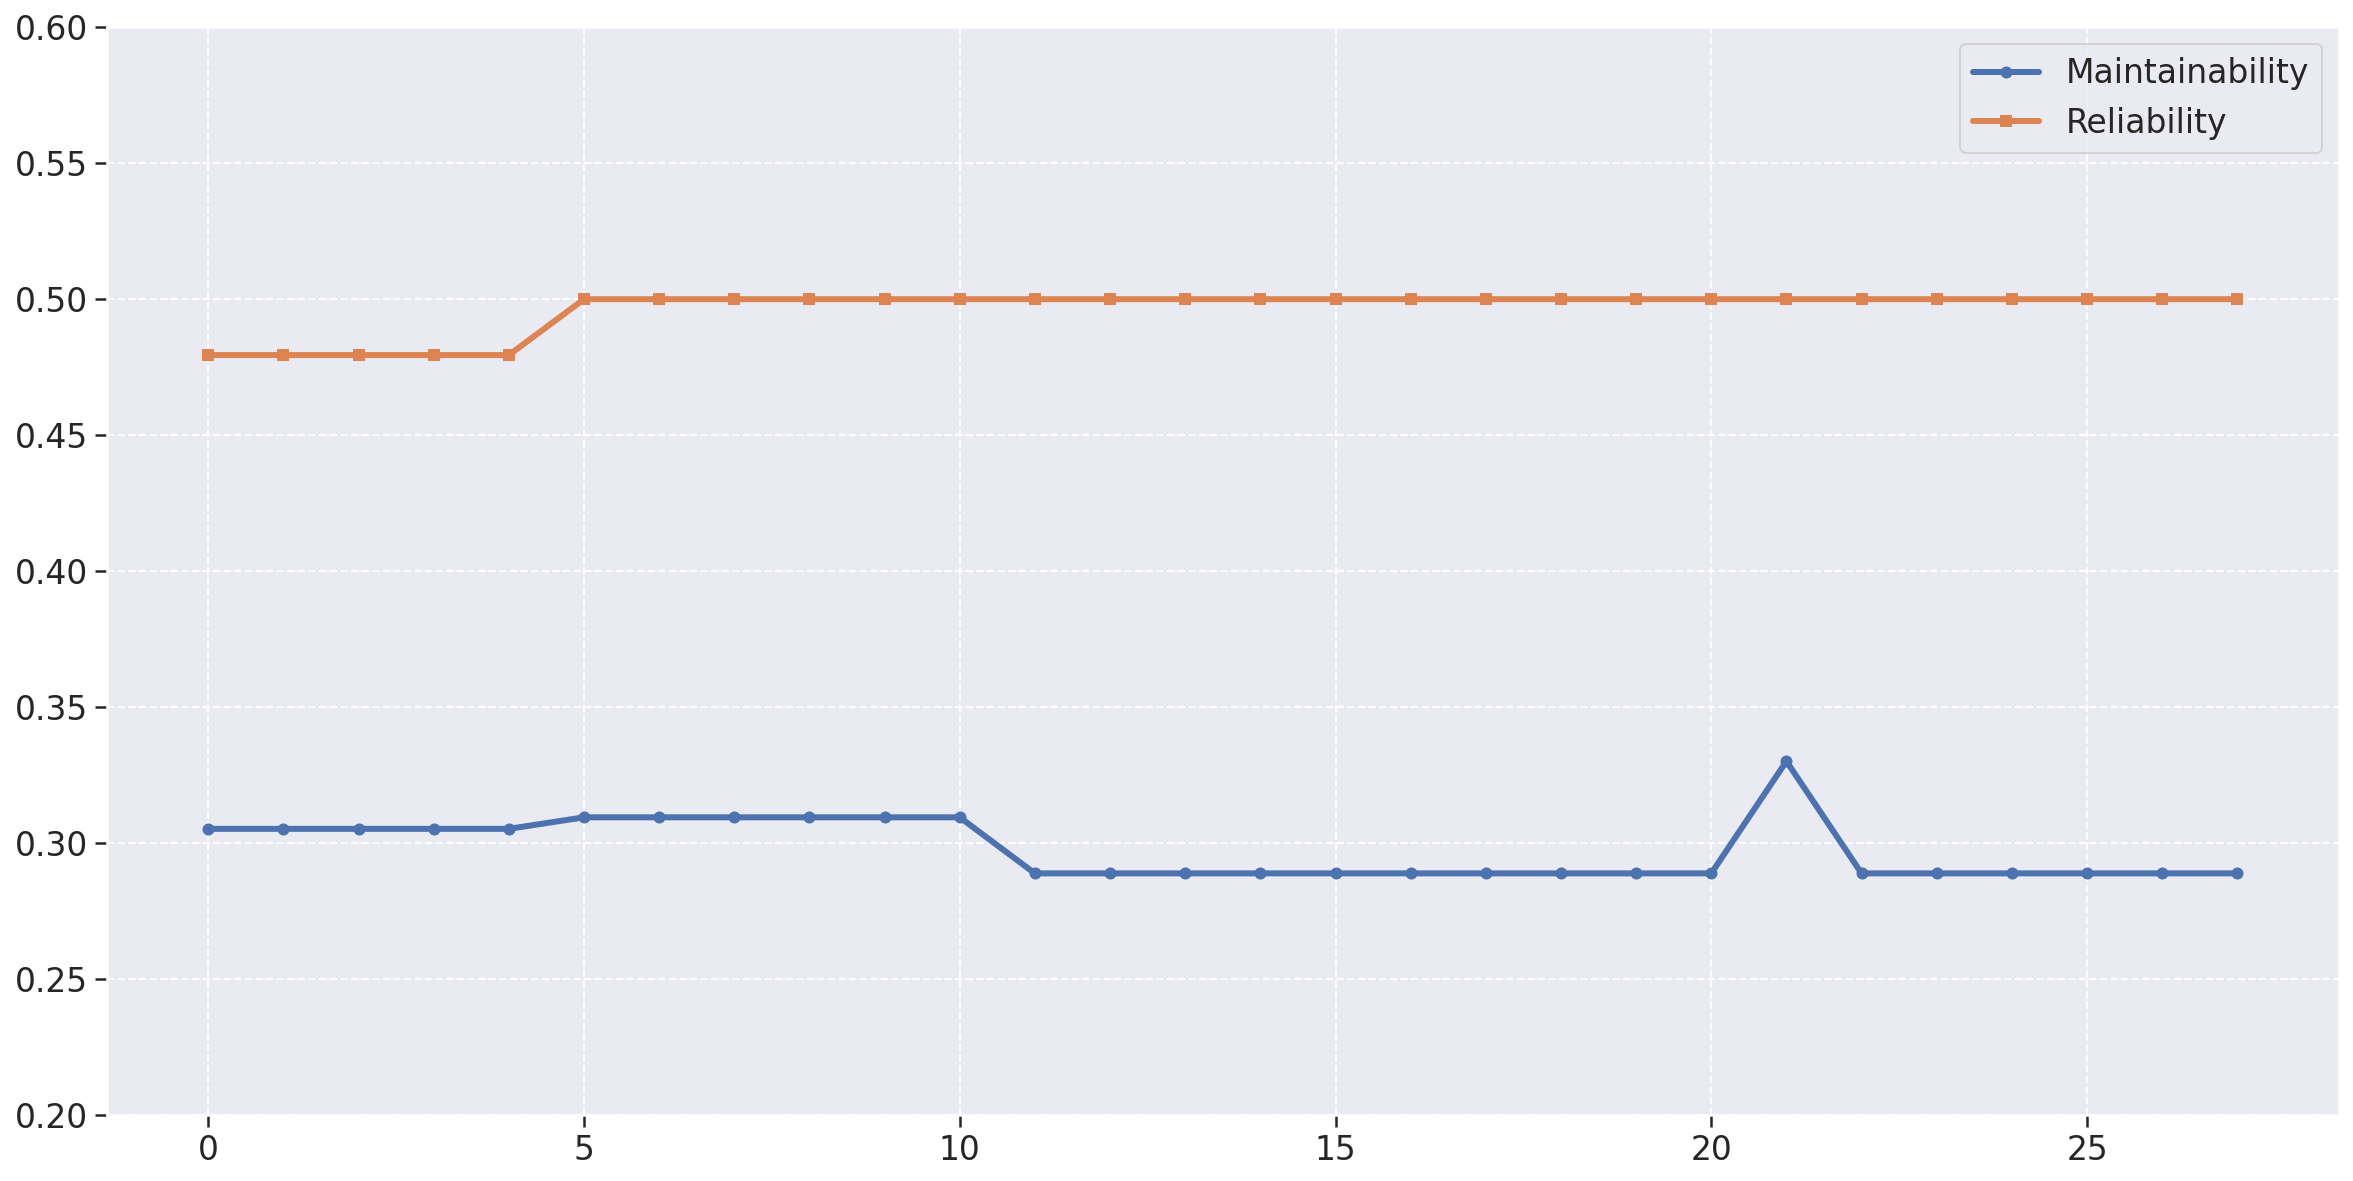

In [30]:
fig = plt.figure(figsize=(20, 10))


plt.plot(metrics_df['maintainability'], linewidth=3, marker='o', label='Maintainability', markersize=5)
plt.plot(metrics_df['Reliability'], linewidth=3, marker='s', label='Reliability', markersize=5)
plt.legend()
plt.ylim(.2,.6)

(0.65, 0.9)

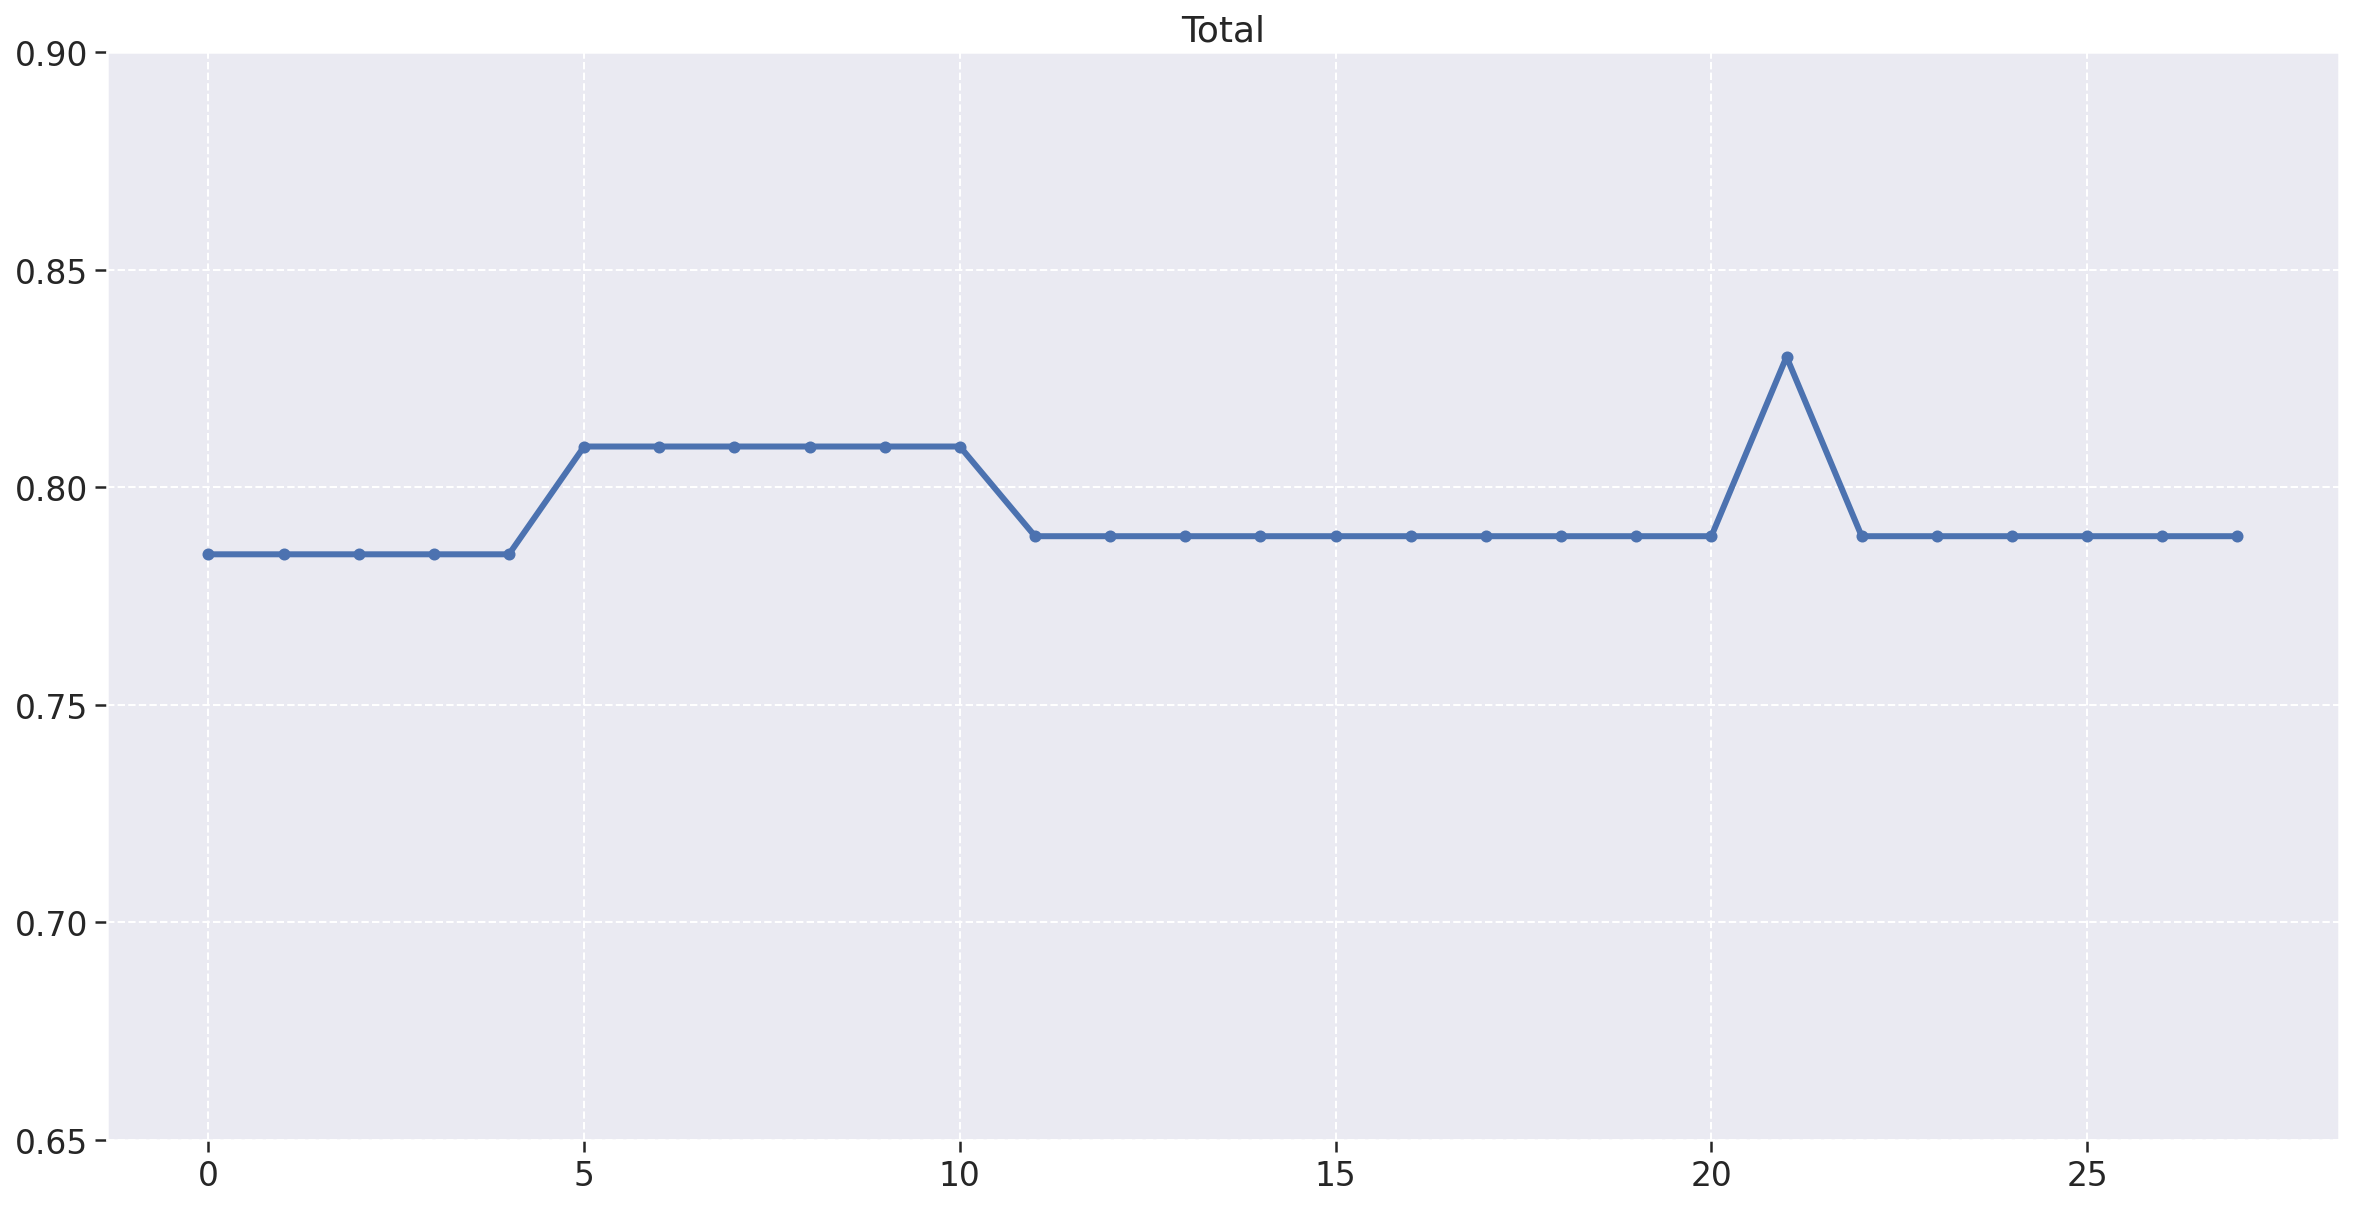

In [31]:
fig = plt.figure(figsize=(20, 10))

plt.title('Total')
plt.plot(metrics_df['total'], linewidth=3, marker='o', markersize=5)
plt.ylim(.65,.9)

In [32]:
# ANALYSIS_DATE FORMAT: YYYY-MM-DD
currentTime = datetime.datetime.now().strftime("%Y-%m-%d")

# metrics_df.to_excel('data/fga-eps-mds-Pro-Especies-DATASET-{}.xlsx'.format(currentTime), index = False)
metrics_df.to_csv('data/fga-eps-mds-Pro-Especies-DATASET-{}.csv'.format(currentTime), index = False)